In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import itertools

from IPython.display import HTML

import os
from datetime import datetime

<ipython-input-4-56454a85c41c>:3: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Spiking Visual attention in Medical Imaging/Datasets/MedicalMNIST.zip"
extract_path = "/content/drive/MyDrive/Spiking Visual attention in Medical Imaging/Datasets/MedicalMNIST Extracted/data/raw"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

## Surrogate Gradient Descent

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{1}$$
$$\frac{\partial S}{\partial U} = \delta(U - U_{\rm thr}) \in \{0, \infty\} \tag{2}$$
$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$
$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$
$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$

In [ ]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
batch_size = 128
data_path='/content/drive/MyDrive/Spiking Visual attention in Medical Imaging/Datasets/MedicalMNIST Extracted/data/raw'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_dataset = datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.8 * len(mnist_dataset))  # 80% for training
test_size = len(mnist_dataset) - train_size  # 20% for testing

mnist_train, mnist_test = random_split(mnist_dataset, [train_size, test_size])

print(len(mnist_train))
print(len(mnist_test))

print(mnist_dataset.class_to_idx)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

47163
11791
{'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [ ]:
print(mnist_dataset.classes)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


## 2.2 Define the Network

The convolutional network architecture to be used is: 12C5-MP2-64C5-MP2-10816FC6

- 12C5 is a 5X5 convolutional kernel with 12 filters
- MP2 is a 2X2 max-pooling function
- 64C5 is a 5X5 convolutional kernel with 64 filters
- MP2 is another a 2X2 max-pooling function
- 10816FC6 is a fully-connected layer that maps 10,816 neurons to 6 outputs

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*13*13, 6)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

In [ ]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*13*13, 6),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [ ]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

In [ ]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 1.792


In [ ]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 10.938%


In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
# test_acc = batch_accuracy(test_loader, net, num_steps)

# print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 17.18%


In [ ]:
def save_checkpoint(model, optimizer, epoch, checkpoint_dir="SCNN_checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}_{timestamp}.pth.tar")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

def load_checkpoint(model, optimizer=None, checkpoint_path="latest_checkpoint.pth"):
    if not os.path.exists(checkpoint_path):
        print("Checkpoint not found!")
        return None

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {checkpoint_path}, Epoch: {epoch}")
    return epoch

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Every 50 iterations, evaluates the model on the test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

    save_checkpoint(net, optimizer, epoch)


Iteration 0, Test Acc: 16.87%

Iteration 50, Test Acc: 95.92%

Iteration 100, Test Acc: 98.08%

Iteration 150, Test Acc: 97.63%

Iteration 200, Test Acc: 98.84%

Iteration 250, Test Acc: 99.33%

Iteration 300, Test Acc: 99.07%

Iteration 350, Test Acc: 99.47%

Checkpoint saved: SCNN_checkpoints/checkpoint_epoch_0_20250403_003734.pth


Note:
train_size=47163 / batch_size=128 = iteration=368.46=350

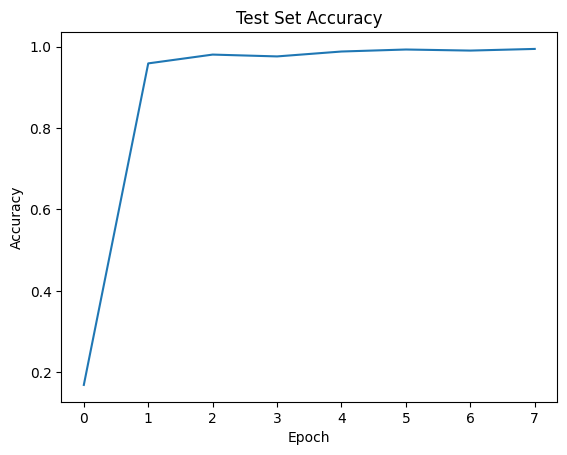

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
print(spk_rec.shape)
labels = [str(i) for i in range(spk_rec.shape[0])]
print(labels)

torch.Size([50, 128, 6])
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']


The target label is: 4


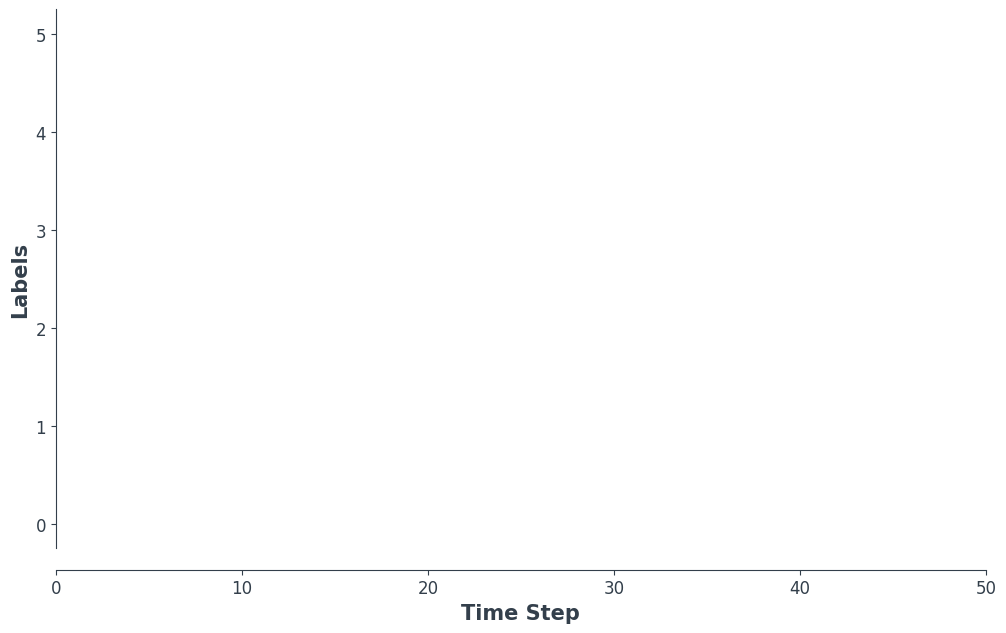

In [ ]:
idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5']
print(f"The target label is: {targets[idx]}")

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

Predicted Class: Hand


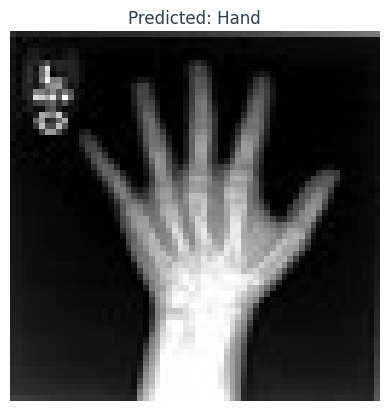

In [ ]:
def predict_image(model, image_path, class_labels):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        spk_rec, _ = model(image)
        predicted_class = torch.argmax(spk_rec, dim=1).item()

    print(f"Predicted Class: {class_labels[predicted_class]}")

    # Plot image
    plt.imshow(Image.open(image_path), cmap="gray")
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis("off")
    plt.show()

class_labels = mnist_dataset.classes
# ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
predict_image(net, "test_image.jpeg", class_labels)